# Object Detection Pipeline - Hyperparameter Tuning & Model Training
This notebook demonstrates the complete pipeline for training different YOLO models on aerial imagery. Besides, Hyperparameter tuning with Ray Tune on validation set, followed by final training on train+val and evaluation on test set.

Github Repo and Documentation of the work : [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

By/ Kshitij Raj Sharma, Sahar Mohamed



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/dl4cv-oda/blob/master/notebooks/train.ipynb)

This dl4cv_oda package includes all the pipline steps and functions for coconut trees, more info in the repo here: [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

In [ ]:
!pip install dl4cv_oda

# Overview for the models

## YOLOv8 – Architecture Summary

**YOLOv8** is the latest state-of-the-art real-time object detection model in the YOLO family developed by Ultralytics. It improves on previous versions with a modern and efficient design that enhances speed and accuracy.

### Core Components
- **Backbone:** A convolutional neural network (CNN) that extracts hierarchical features from input images.
- **Neck:** Combines multi-scale features to help detect objects of different sizes; uses modules like FPN/PAN variants.
- **Head:** A prediction module that outputs object bounding boxes and class scores in one forward pass.

### Key Improvements
- **Anchor-free detection:** Predicts object centers directly instead of relying on predefined anchor boxes.
- **C2f modules:** An enhanced feature block that replaces older C3 blocks, improving feature extraction efficiency. :contentReference[oaicite:5]{index=5}  
- **Split head design:** Decouples classification and regression for better optimization and accuracy.  
- **Multi-task support:** Works for detection, segmentation, classification, and pose estimation within a unified API.

YOLOv8 excels at balancing high speed and competitive accuracy**, especially for real-time applications and custom datasets.

-------------------------------------------------------------------
## **YOLOv12 – Architecture Summary**

**YOLOv12** is the newest evolution of the YOLO family, introducing **attention mechanisms** into the YOLO framework to improve performance while maintaining real-time speeds.

### What’s New
YOLOv12 combines the rapid inference of CNN-based detectors with the **enhanced modeling power of attention**, achieving both speed and accuracy improvements.

### Core Innovations
- **Area Attention Module:** Efficient attention mechanism that scales well with high-resolution feature maps, enhancing context awareness.
- **Residual Efficient Layer Aggregation Networks (R-ELAN):** A powerful backbone that improves feature extraction efficiency and gradient flow.
- **Architectural Enhancements:** Optimized connectivities and attention-friendly layers to balance compute cost and detection performance.

### Advantages
- **Better context modeling** than pure CNNs  
- Stronger performance on small and detailed objects  
- Competitive speed performance due to attention-centric design

YOLOv12 sets a new benchmark for real-time object detection by merging attention mechanisms with efficient architecture, pushing performance beyond earlier YOLO versions.

Source: Ultralytics

-------------------------------------------------------------------

## **RT-DETR (Real-Time Detection Transformer)**
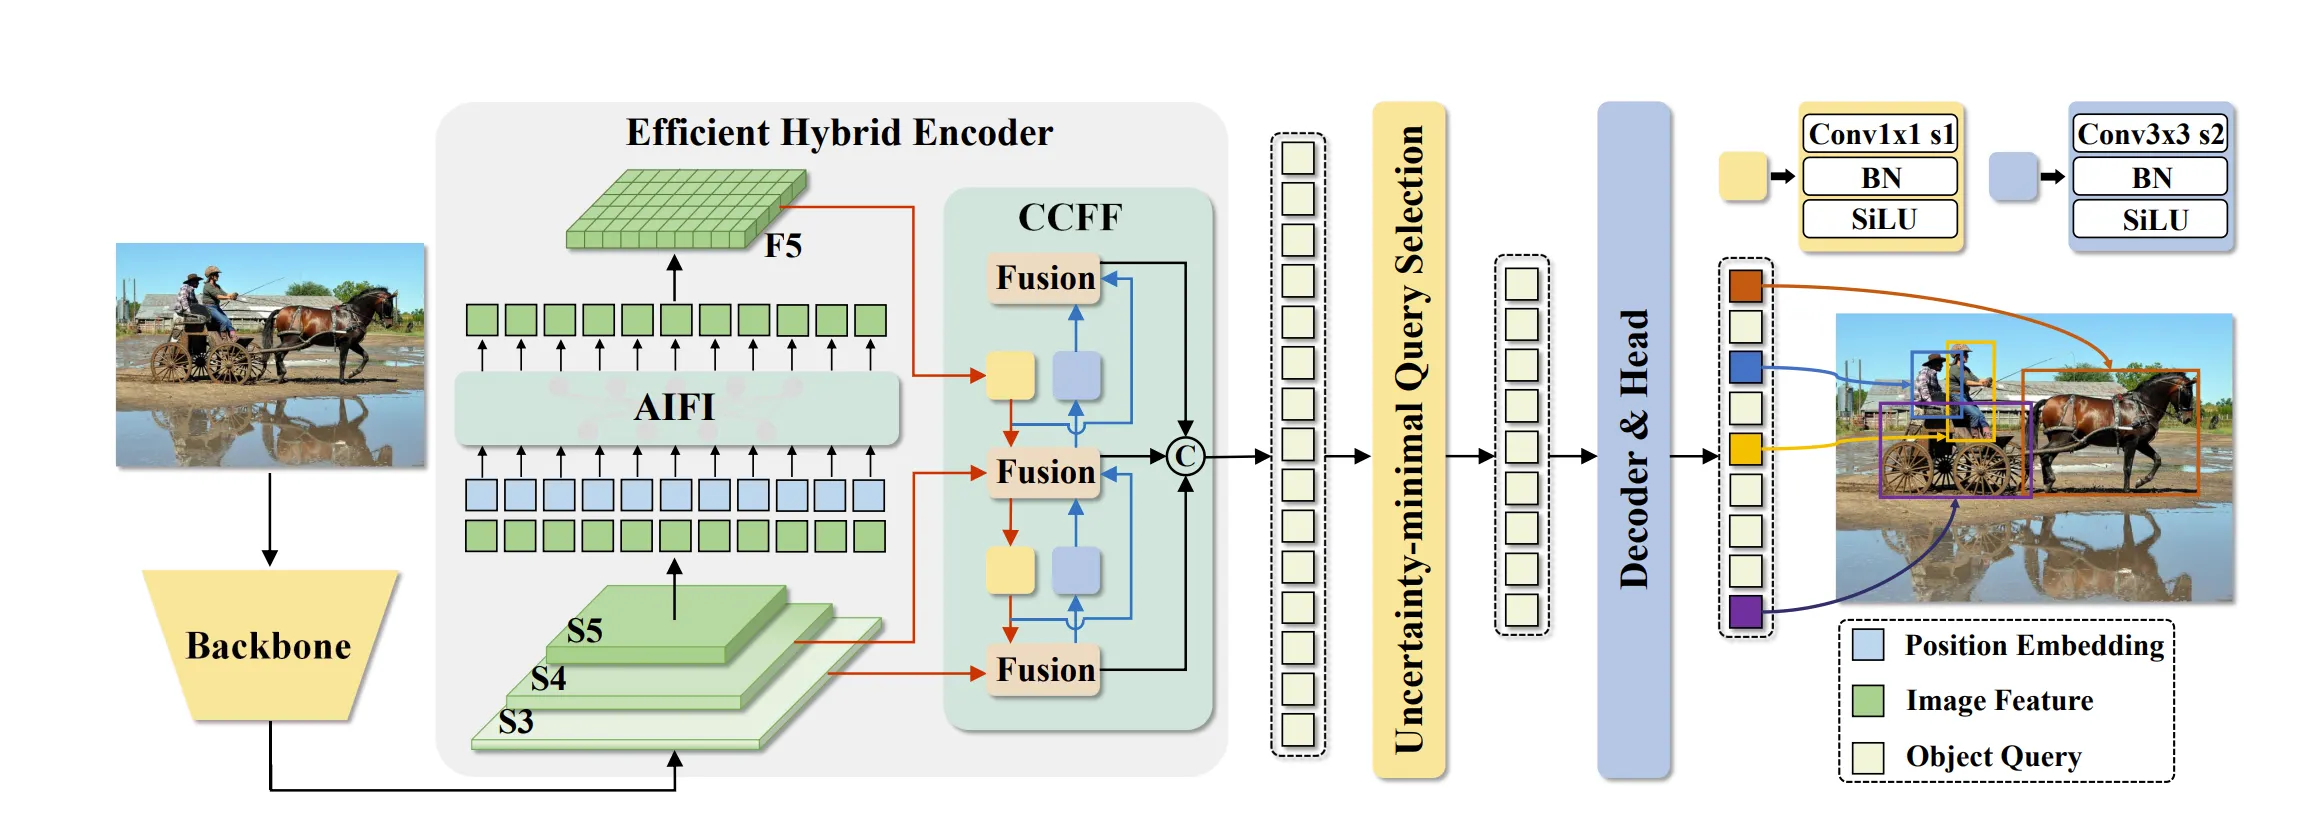

RT-DETR is the first **real-time, end-to-end object detector** based on Transformers. Unlike YOLO-style detectors, it **removes Non-Maximum Suppression (NMS)** and directly predicts a fixed set of objects in one forward pass.

### Key Ideas
- **Hybrid Encoder:** Efficient multi-scale feature fusion with lower computational cost than standard Transformers.
- **Uncertainty-Minimal Query Selection:** Selects high-confidence features to initialize object queries, improving localization and detection of small or dense objects.
- **End-to-End Detection:** No anchors and no NMS, leading to simpler and more stable inference.

### Highlights
- Strong performance in crowded scenes
- Better global context modeling than CNN-only detectors
- Real-time capable on GPUs (slower on CPU/MPS)

RT-DETR bridges the gap between DETR accuracy and YOLO speed by combining efficient Transformer design with end-to-end detection.




## Step 1 : Data Preprocessing

In [1]:
import requests
import geopandas as gpd
from pathlib import Path
from dl4cv_oda import (clean_osm_data, clip_labels_to_tiles, convert_to_yolo_format,
                       create_train_val_split, create_yolo_config, download_tiles)

In [ ]:
## Import data paths
DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
CHIPS_DIR = DATA_DIR / "chips"
LABELS_DIR = DATA_DIR / "labels"
YOLO_DIR = DATA_DIR / "yolo"

OSM_FILE = RAW_DIR / "kolovai-trees.geojson" ## original file
CLEANED_FILE = RAW_DIR / "cleaned.geojson"   ## cleaned file for focusing on the trees
TREES_BOX_FILE = DATA_DIR / "trees_box.geojson"  ## buffers file
TILES_FILE = DATA_DIR / "tiles.geojson"   ## tiles file from mercantile library

if not OSM_FILE.exists():
    OSM_FILE.parent.mkdir(parents=True, exist_ok=True)
    OSM_FILE.write_bytes(requests.get("https://github.com/kshitijrajsharma/dl4cv-oda/blob/master/data/raw/kolovai-trees.geojson?raw=true", allow_redirects=True).content)
    print(f"Downloaded OSM data")  ## downloading the tif image from our repo in case you don't have one , change the path of img and labels below.

if not CLEANED_FILE.exists():
    count = clean_osm_data(str(OSM_FILE), str(CLEANED_FILE), str(TREES_BOX_FILE))
    print(f"Cleaned {count} trees") ## numbers of trees from the cleaned geojson file

if not TILES_FILE.exists():
    data = gpd.read_file(TREES_BOX_FILE)
    data.to_crs(epsg=4326, inplace=True) ## starndrasize the same crs
    bbox = list(data.total_bounds)
    await download_tiles(bbox, 19, "https://tiles.openaerialmap.org/5a28639331eff4000c380690/0/5b1b6fb2-5024-4681-a175-9b667174f48c/{z}/{x}/{y}.png", DATA_DIR, 'OAM')
    print("Downloaded tiles")

#### Step 1.1 Train - Val Split and Configuration

In [ ]:
if not (YOLO_DIR / "train").exists():
    stats = clip_labels_to_tiles(str(TREES_BOX_FILE), str(TILES_FILE), str(LABELS_DIR)) ## assign labels to each tile 
    print(f"Clipped {stats['total_trees']} trees to {stats['processed']} tiles")

    ## converting to yolo format and filter for only coconut trees for avoid class imbalance
    class_mapping = convert_to_yolo_format(str(TREES_BOX_FILE), str(CHIPS_DIR), str(LABELS_DIR), str(YOLO_DIR), target_species="Coconut")
    print(f"Converted to YOLO format")

    ## splitting the data to 70% 20% and 10%
    train_count, val_count, test_count = create_train_val_split(str(LABELS_DIR), str(CHIPS_DIR), str(YOLO_DIR), train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42)
    print(f"Split: train={train_count}, val={val_count}, test={test_count}")

    ## create config file yaml file for yolo training
    config_file = create_yolo_config(str(YOLO_DIR), {"Coconut": 0})
    print(f"Config: {config_file}")

print("Data preparation complete")

Clipped 12337 trees to 458 tiles
Converted to YOLO format
Split: train=320, val=93, test=45
Config: ../data/yolo/config.yaml
Data preparation complete


## Runtime configuration

In [ ]:
IMG_SIZE = 256
EPOCHS = 200
PATIENCE = 30 ## increase to 30 (not 10)
BATCH_SIZE = 16

##models (YOLOv8, YOLOv12, RTDETR) larg models as we found that RTDERT has only large and xl models
MODELS_TO_TRAIN = {
    "yolov8l": "yolov8l.pt",
    "yolo12l": "yolo12l.pt",
    "rtdetr-l": "rtdetr-l.pt"
}

# Traing with default parameters

In [18]:
from ultralytics import YOLO, RTDETR

for model_name, model_weights in MODELS_TO_TRAIN.items():
    print(f"Training {model_name}...")
    # Initialize the model with pretrained weights
    model = YOLO(model_weights)

    # Train the model
    model.train(
        data= str(YOLO_DIR / "config.yaml"), # Path to the dataset configuration file
        imgsz=IMG_SIZE,     # Image size
        epochs=EPOCHS,    # Number of epochs
        batch=BATCH_SIZE,   # Batch size
        patience=PATIENCE,  # Early stopping patience
        name=f"yolo_{model_name}_tuned"
    )
    print(f"Finished training {model_name}")
    print("\n" + "="*50 + "\n")

Training yolov8l...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/yolo/config.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_yolov8l_tuned2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/200      7.65G      1.816     0.3951     0.6073        362        256: 100% ━━━━━━━━━━━━ 20/20 1.6it/s 12.8s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846     0.0634      0.492     0.0581     0.0178

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      2/200      7.74G       1.34     0.4947     0.2822        318        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/200      7.74G      1.177     0.4857     0.2885        600        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.553      0.455      0.433      0.146

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      3/200      7.79G     0.9725     0.5216     0.2212        448        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/200      7.79G      0.992     0.4781        0.2        516        256: 100% ━━━━━━━━━━━━ 20/20 1.7it/s 11.5s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.657      0.548      0.516      0.162

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      4/200      7.79G     0.9606     0.4629     0.1935        504        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/200      8.83G      0.934     0.4632     0.1784        548        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.319      0.367      0.179     0.0319

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      5/200      5.75G      0.889     0.4524     0.1577        519        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/200      6.45G     0.9041     0.4671     0.1816        427        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.311      0.285      0.173     0.0321

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      6/200      6.46G     0.8931     0.4548     0.1624        783        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/200       6.5G     0.8712     0.4856     0.1618        405        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.129      0.118     0.0333    0.00644

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      7/200      6.55G     0.8935      0.468     0.1349        561        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/200      7.31G     0.8704     0.4752     0.1598        540        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846     0.0262     0.0239      0.003   0.000525

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      8/200      7.35G     0.7991     0.4845     0.1214        602        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/200       7.4G     0.8777     0.4645     0.1678        516        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.716      0.637      0.596      0.213

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      9/200      7.44G     0.7959     0.4828     0.1461        540        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/200      7.49G      0.843     0.4699     0.1544        640        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.551      0.475      0.379     0.0734

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     10/200      7.49G     0.8126     0.4682     0.1276        573        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/200      7.49G     0.8215     0.4784     0.1366        414        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846       0.73      0.633      0.596      0.204

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     11/200      7.49G     0.8451     0.4466     0.1491        614        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/200      7.49G     0.7762     0.4805      0.132        429        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.726      0.672      0.614      0.229

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     12/200      7.49G     0.7236     0.4743     0.1206        608        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/200      7.49G     0.7963     0.4787     0.1423        627        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.742       0.69      0.645      0.261

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     13/200      7.49G     0.8512     0.4506     0.1531        723        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/200      7.49G     0.7944     0.4854     0.1371        539        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.6s
                   all         93       2846       0.75      0.685      0.653      0.292

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     14/200      7.49G     0.9013     0.4518     0.1727        637        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/200      7.49G     0.7763     0.4811     0.1323        451        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.713      0.663      0.601      0.198

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     15/200      7.53G     0.7633     0.4564     0.1257        625        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/200      7.58G       0.81     0.4789     0.1442        666        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.6s
                   all         93       2846      0.762      0.689      0.665      0.298

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     16/200      7.58G     0.6686     0.5004     0.1305        511        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/200      7.58G     0.7881       0.49     0.1394        489        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.638      0.616      0.533      0.131

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     17/200      7.58G     0.7681     0.4692     0.1289        744        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/200      7.58G     0.7603      0.502     0.1301        723        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.672      0.615      0.552      0.174

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     18/200      7.58G      0.877     0.4458     0.1555        591        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/200      7.58G     0.7789     0.4849     0.1302        495        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.718      0.676      0.616      0.223

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     19/200      7.58G      0.718      0.503     0.1351        459        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/200      7.58G     0.7759     0.4828     0.1325        636        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.735      0.691      0.645      0.268

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     20/200      7.58G      0.746     0.4841     0.1353        479        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/200      7.58G      0.751     0.4923     0.1296        525        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.722      0.685      0.629      0.234

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     21/200      7.58G     0.8236     0.4454     0.1501        603        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/200      7.58G      0.776     0.4797     0.1314        509        256: 100% ━━━━━━━━━━━━ 20/20 1.7it/s 11.8s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.734       0.67      0.633      0.259

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     22/200      7.58G     0.7036     0.5347     0.1192        464        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/200      7.58G     0.7382     0.5009     0.1307        435        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.748      0.687       0.65      0.282

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     23/200      7.58G     0.7826     0.5089     0.1153        390        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/200      7.58G     0.7565     0.4895     0.1224        681        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.734      0.669      0.621       0.23

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     24/200      7.58G      0.831     0.4726     0.1353        547        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/200      7.58G     0.7619     0.4886     0.1288        616        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.713      0.679      0.623      0.225

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     25/200      7.58G     0.8074     0.4774     0.1615        503        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/200      7.58G      0.762      0.479      0.132        538        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846       0.74      0.698      0.657      0.283

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     26/200      7.58G     0.7171     0.4715     0.1031        581        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/200      7.58G     0.7409     0.4866     0.1286        576        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.753      0.704      0.669      0.307

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     27/200      7.58G     0.8216     0.4938     0.1516        401        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/200      7.58G     0.7643     0.4879     0.1256        778        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.729      0.666      0.621      0.235

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     28/200      7.58G     0.7203     0.4806     0.1164        615        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/200      7.58G     0.7323     0.4923     0.1201        457        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.734      0.687      0.634      0.246

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     29/200      7.58G     0.6456     0.5135    0.09824        477        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/200      7.58G     0.7301     0.4864     0.1149        452        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.747      0.678      0.639      0.257

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     30/200      7.58G     0.7595     0.4701     0.1095        585        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/200      7.58G     0.7402     0.4819     0.1198        636        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.668      0.615      0.542      0.119

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     31/200      7.58G     0.7612     0.4776     0.1381        691        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/200      7.58G     0.7462     0.4881      0.137        433        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.761      0.712      0.671      0.311

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     32/200      7.58G     0.6935     0.5509     0.1255        401        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/200      7.58G     0.7087     0.4983     0.1173        610        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.703      0.672      0.599      0.173

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     33/200      7.58G     0.7389     0.4998     0.1139        477        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/200      7.58G     0.7283     0.4866     0.1187        497        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.751       0.68      0.636      0.254

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     34/200      7.58G     0.8001     0.4742     0.1216        453        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/200      7.58G     0.7568     0.4869     0.1322        383        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.704      0.659       0.59      0.178

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     35/200      7.58G     0.7119     0.4837     0.1107        533        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/200      7.58G      0.713     0.4887     0.1151        562        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.628      0.574      0.485      0.106

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     36/200      7.58G     0.7325     0.4537     0.1142        502        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/200      8.35G     0.7286     0.4943     0.1285        428        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.735      0.665      0.612      0.194

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     37/200      5.28G     0.7918     0.4826     0.1395        631        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/200      5.81G     0.7248     0.4866     0.1222        526        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.749      0.678      0.635      0.255

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     38/200      6.26G     0.7632     0.4631     0.1135        627        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/200      6.31G      0.705     0.4989     0.1136        470        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.736      0.694      0.635      0.253

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     39/200      6.35G     0.7115     0.4755     0.1102        498        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     39/200       6.4G     0.7286     0.4873     0.1183        541        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846      0.753      0.702      0.651      0.288

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     40/200      6.44G      0.671     0.5338     0.1124        399        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     40/200      7.63G     0.7266     0.4892     0.1188        419        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846       0.76      0.695      0.651      0.278

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     41/200      7.68G     0.6879     0.5191     0.1119        454        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     41/200      7.72G     0.7137     0.4931     0.1139        725        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.694      0.644      0.279

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     42/200      7.72G     0.8127     0.4725     0.1438        538        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     42/200      7.72G     0.6996     0.4874     0.1137        502        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.754      0.708      0.663      0.305

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     43/200      7.72G     0.6664     0.4851      0.108        483        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     43/200      7.72G     0.7105     0.4796     0.1147        704        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.736      0.662      0.617      0.198

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     44/200      7.72G     0.7374     0.4712     0.1034        613        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     44/200      7.72G     0.7007     0.4883     0.1101        457        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.755       0.71      0.663      0.305

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     45/200      7.72G     0.6567     0.4767     0.1208        393        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     45/200      8.43G      0.704     0.4798     0.1137        559        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.732      0.697      0.644      0.267

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     46/200      5.41G     0.7126     0.5297     0.1261        335        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     46/200      6.17G     0.7012      0.497     0.1153        617        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.681      0.641      0.264

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     47/200      6.17G     0.7194     0.4655     0.1242        640        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     47/200       6.9G     0.7017     0.4819     0.1101        446        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.4s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.717      0.665      0.294

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     48/200      6.94G     0.6493      0.511     0.1098        419        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     48/200      6.99G     0.6951     0.4885     0.1131        385        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846       0.75      0.703       0.66      0.271

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     49/200      7.03G      0.764     0.5169     0.1202        388        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     49/200      7.08G     0.7258     0.4865     0.1202        577        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.723      0.669      0.611      0.191

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     50/200      7.12G     0.6859     0.5027     0.1525        348        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     50/200      7.17G      0.711     0.4951      0.126        655        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.722       0.67      0.605      0.185

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     51/200      7.17G     0.7467     0.4988     0.1577        432        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     51/200      7.17G     0.6997     0.4844     0.1169        615        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.683      0.626       0.55       0.15

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     52/200      7.17G     0.6805     0.4743     0.1127        493        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     52/200      7.17G     0.6848     0.4936      0.105        543        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.752       0.69      0.647      0.266

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     53/200      7.17G     0.6948     0.5145     0.1212        556        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     53/200      7.17G     0.6863     0.5013     0.1106        511        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846       0.74      0.684      0.629      0.235

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     54/200      7.17G     0.6824     0.4832     0.1187        503        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     54/200      7.17G     0.7007     0.4927     0.1199        366        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.759      0.697      0.653      0.272

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     55/200      7.17G     0.7517     0.5283     0.1371        294        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     55/200      7.17G      0.701     0.4874     0.1197        497        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.713      0.667      0.612      0.197

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     56/200      7.21G     0.6776      0.493    0.09652        436        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     56/200      7.26G      0.696     0.4843     0.1104        555        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.711      0.674      0.619      0.226

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     57/200      7.96G     0.7281     0.4693     0.1102        683        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     57/200      8.71G      0.686     0.4892      0.108        426        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.4s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.721      0.686      0.622      0.238

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     58/200      4.86G     0.6459     0.4883     0.1017        486        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     58/200      5.99G     0.7037     0.4889      0.122        577        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.748      0.707      0.642      0.283

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     59/200      5.99G     0.6603      0.492     0.1206        480        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     59/200      5.99G     0.7053     0.4897     0.1165        613        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.738      0.696      0.631      0.247

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     60/200      6.45G     0.6606     0.4803     0.1007        505        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     60/200      7.76G     0.6951     0.4888     0.1145        646        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.689      0.643      0.256

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     61/200      7.81G     0.6879     0.4905     0.1117        575        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     61/200      7.85G     0.6814     0.4883      0.109        727        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.744       0.68      0.644      0.271
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

61 epochs completed in 0.227 hours.
Optimizer stripped from /kaggle/working/runs/detect/yolo_rtdetr-l_tuned2/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/runs/detect/yolo_rtdetr-l_tuned2/weights/best.pt, 66.2MB

Validating /kaggle/working/runs/detect/yolo_rtdetr-l_tuned2/weights/best.pt...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P10

## Step 2 : Hyper Parameter Tuning

In [ ]:
#!pip install optuna

In [20]:
from pathlib import Path
import yaml
import optuna
from ultralytics import RTDETR, YOLO

# EPOCHS = 200
TUNE_EPOCHS = 100
TUNE_TRIALS = 10

DATA_YAML = str(YOLO_DIR / "config.yaml")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

def tune_model(model, model_name):
    #Tune lr0, weight_decay, batch and returns best_params dict
    def objective(trial):
        lr0 = trial.suggest_float("lr0", 1e-5, 1e-2, log=True)
        weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
        batch = trial.suggest_categorical("batch", [8, 16, 32])

        try:
            model.train(
                data=DATA_YAML,
                epochs=TUNE_EPOCHS,
                imgsz=IMG_SIZE,
                batch=batch,
                lr0=lr0,
                weight_decay=weight_decay,
                device=0,
                verbose=False,
                save=True
            )

            # evaluate on validation split
            val_metrics = model.val(split="val", verbose=False)

            # extract precision & recall from DetMetrics.box
            p = float(val_metrics.box.mp)   # mean precision
            r = float(val_metrics.box.mr)   # mean recall
            f1 = 2 * (p * r) / (p + r + 1e-6)
            map50 = float(val_metrics.box.map50)
            return f1, map50

        except Exception as e:
            print(f"[tunefail] {model_name} trial failed: {e}")
            return 0.0

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=TUNE_TRIALS, show_progress_bar=True)

    best_params = study.best_params
    print(f"[{model_name}] best params (by val F1): {best_params}")

    # Save YAML for reproducibility
    save_path = RESULTS_DIR / f"{model_name}_best_hyperparameters.yaml"
    with open(save_path, "w") as f:
        yaml.safe_dump(best_params, f)

    return best_params


## Step 3 : Model Training with best hyperparameters

In [21]:
results = []

for name, weights in MODELS_TO_TRAIN.items():
    print(f"\n Processing {name}")
    model = RTDETR(weights) if "rtdetr" in name.lower() else YOLO(weights)

    # Tune
    best_hyperparams = tune_model(weights, name) # Passing weights

    # Retrain with best hyperparameters
    model.train(
        data=DATA_YAML,
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=best_hyperparams.get("batch_size", BATCH_SIZE),
        lr0=best_hyperparams.get("lr0"), ## using default lr=1e-3 in case optuna didn't find best one. ##("lr0", 1e-3)
        weight_decay=best_hyperparams.get("weight_decay"),
        patience=PATIENCE,
        device=0,
        verbose=False,
        name=f"{name}_final",
    )

    # Evaluate
    val_metrics = model.val(split="val", verbose=False)
    test_metrics = model.val(split="test", verbose=False)

    val_p, val_r = float(val_metrics.box.mp), float(val_metrics.box.mr)
    test_p, test_r = float(test_metrics.box.mp), float(test_metrics.box.mr)
    val_f1 = 2 * (val_p * val_r) / (val_p + val_r + 1e-6)
    test_f1 = 2 * (test_p * test_r) / (test_p + test_r + 1e-6)

    results.append({
        "model": name,
        "val_precision": val_p,
        "val_recall": val_r,
        "val_f1": val_f1,
        "val_map50": float(val_metrics.box.map50),
        "test_precision": test_p,
        "test_recall": test_r,
        "test_f1": test_f1,
        "test_map50": float(test_metrics.box.map50),
    })

    print(f"[{name}] Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}, Test mAP50: {results[-1]['test_map50']:.4f}")

# save all results
import pandas as pd
pd.DataFrame(results).to_csv(RESULTS_DIR / "experiment_results.csv", index=False)


 Processing yolov8l


[I 2026-01-12 22:07:20,346] A new study created in memory with name: no-name-9cf97e0f-c359-4978-96bd-1d54ff4885c1
/usr/local/lib/python3.12/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[tunefail] yolov8l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:07:20,360] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.005407155311528174, 'weight_decay': 0.0008632947415287985, 'batch': 8}. Best is trial 0 with value: 0.0.
[tunefail] yolov8l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:07:20,362] Trial 1 finished with value: 0.0 and parameters: {'lr0': 5.2911150756350006e-05, 'weight_decay': 4.890880451303148e-05, 'batch': 32}. Best is trial 0 with value: 0.0.
[tunefail] yolov8l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:07:20,364] Trial 2 finished with value: 0.0 and parameters: {'lr0': 2.0927509119639552e-05, 'weight_decay': 8.993335289958578e-06, 'batch': 8}. Best is trial 0 with value: 0.0.
[tunefail] yolov8l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:07:20,367] Trial 3 finished with value: 0.0 and parameters: {'lr0': 0.00028828800719834483, 'weight_decay': 0.00079149

[I 2026-01-12 22:18:24,029] A new study created in memory with name: no-name-68047c25-8218-42b0-9ccd-3af3d7de26e8
/usr/local/lib/python3.12/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[tunefail] yolo12l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:18:24,040] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.007582505434901912, 'weight_decay': 5.8115404971473024e-05, 'batch': 16}. Best is trial 0 with value: 0.0.
[tunefail] yolo12l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:18:24,042] Trial 1 finished with value: 0.0 and parameters: {'lr0': 0.00011494387086671406, 'weight_decay': 0.00013100798254420468, 'batch': 32}. Best is trial 0 with value: 0.0.
[tunefail] yolo12l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:18:24,045] Trial 2 finished with value: 0.0 and parameters: {'lr0': 0.00328925213716981, 'weight_decay': 0.0009833921730220644, 'batch': 16}. Best is trial 0 with value: 0.0.
[tunefail] yolo12l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:18:24,047] Trial 3 finished with value: 0.0 and parameters: {'lr0': 0.0012770417675636722, 'weight_decay': 3.67788790

[I 2026-01-12 22:32:53,312] A new study created in memory with name: no-name-9fdb2f11-6ab6-453b-9df7-85873b2ef3f6
/usr/local/lib/python3.12/dist-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[tunefail] rtdetr-l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:32:53,322] Trial 0 finished with value: 0.0 and parameters: {'lr0': 0.006024286642167119, 'weight_decay': 0.00021406883761810352, 'batch': 8}. Best is trial 0 with value: 0.0.
[tunefail] rtdetr-l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:32:53,325] Trial 1 finished with value: 0.0 and parameters: {'lr0': 0.007035156861165935, 'weight_decay': 2.873201393593973e-05, 'batch': 8}. Best is trial 0 with value: 0.0.
[tunefail] rtdetr-l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:32:53,327] Trial 2 finished with value: 0.0 and parameters: {'lr0': 0.0003680967595107544, 'weight_decay': 1.8021003471464587e-05, 'batch': 32}. Best is trial 0 with value: 0.0.
[tunefail] rtdetr-l trial failed: 'str' object has no attribute 'train'
[I 2026-01-12 22:32:53,330] Trial 3 finished with value: 0.0 and parameters: {'lr0': 3.5545436092909606e-05, 'weight_decay': 0.00061

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/200      7.76G       1.79     0.4066     0.5858        362        256: 100% ━━━━━━━━━━━━ 20/20 1.6it/s 12.6s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846     0.0615      0.495     0.0595     0.0163

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      2/200      7.81G      1.237      0.556     0.2691        318        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/200      7.81G       1.18     0.4829     0.3026        600        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.524      0.473      0.424      0.137

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      3/200      7.81G     0.9996     0.5232     0.2521        448        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/200      7.81G     0.9937     0.4755     0.2009        516        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846      0.538      0.397      0.348     0.0851

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      4/200      7.81G     0.9763     0.4602     0.2019        504        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/200      8.85G     0.9185       0.47     0.1761        548        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846      0.675      0.552      0.509      0.145

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      5/200      5.79G     0.9276     0.4408     0.1773        519        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/200      6.49G     0.9209     0.4597     0.1865        427        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846      0.343      0.311       0.17     0.0308

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      6/200      6.49G     0.9061     0.4601     0.1428        783        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/200      6.51G     0.8769     0.4765     0.1582        405        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846      0.464      0.374      0.275      0.057

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      7/200      6.55G     0.8806     0.4691     0.1325        561        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/200      7.32G     0.8715     0.4706     0.1629        540        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.6it/s 0.8s0.6s
                   all         93       2846      0.158      0.132     0.0519    0.00816

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      8/200      7.36G     0.8191     0.4668      0.141        602        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/200      7.41G     0.8626     0.4705     0.1584        516        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.682      0.584      0.524      0.134

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
      9/200      7.45G     0.7758     0.5091     0.1274        540        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/200       7.5G     0.8456     0.4766     0.1559        640        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.724      0.656       0.62      0.243

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     10/200       7.5G     0.8435     0.4671     0.1502        573        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/200       7.5G     0.8267     0.4777     0.1433        414        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.719      0.604      0.559      0.177

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     11/200       7.5G     0.8048     0.4751     0.1243        614        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/200       7.5G     0.7719     0.4861     0.1291        429        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.725      0.665      0.602      0.264

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     12/200       7.5G     0.7602     0.4669     0.1409        608        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/200       7.5G     0.7977     0.4785     0.1449        627        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846       0.45      0.434       0.28     0.0444

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     13/200       7.5G     0.8416     0.4447     0.1308        723        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/200       7.5G     0.8029     0.4886      0.137        539        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.749      0.686       0.65       0.27

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     14/200       7.5G     0.9209     0.4481      0.172        637        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/200       7.5G     0.7952     0.4776      0.139        451        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.709      0.658      0.608      0.211

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     15/200      7.54G     0.7546     0.4877     0.1164        625        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/200      7.59G      0.791     0.4914     0.1417        666        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.735      0.675       0.63      0.255

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     16/200      7.63G     0.6745     0.4893     0.1287        511        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/200      7.67G     0.7826     0.4902      0.138        489        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.724      0.682      0.632      0.243

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     17/200      7.67G     0.7646     0.4703     0.1264        744        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/200      7.67G     0.7661     0.4829     0.1328        723        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.755      0.705      0.661      0.293

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     18/200      7.67G     0.8868     0.4502     0.1457        591        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/200      7.67G     0.7981     0.4762     0.1405        495        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.722       0.68      0.625       0.21

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     19/200      7.67G      0.747     0.4953     0.1496        459        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/200      7.67G     0.7735     0.4774     0.1339        636        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.327      0.298       0.16     0.0235

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     20/200      7.67G     0.8122     0.4686     0.1628        479        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/200      7.67G     0.7698     0.4985     0.1441        525        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.723      0.658      0.605      0.186

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     21/200      7.67G     0.7666     0.4818     0.1216        603        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/200      7.67G     0.7829     0.4822     0.1288        509        256: 100% ━━━━━━━━━━━━ 20/20 1.7it/s 11.4s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.651      0.605      0.528      0.132

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     22/200      7.67G     0.6968     0.5226     0.1188        464        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/200      7.67G     0.7422     0.4946     0.1316        435        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.763      0.713      0.678      0.316

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     23/200      7.67G     0.7604     0.5189     0.1239        390        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/200      7.67G     0.7595     0.4933      0.124        681        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.633      0.586      0.494      0.101

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     24/200      7.67G     0.8196     0.4838     0.1359        547        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/200      7.67G     0.7543     0.4883      0.126        616        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.725      0.665      0.626      0.228

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     25/200      7.67G     0.7751     0.4896     0.1491        503        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/200      7.67G     0.7614     0.4807     0.1311        538        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.722      0.665      0.615      0.217

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     26/200      7.67G     0.7442     0.4699     0.1036        581        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/200      7.67G     0.7394     0.4836      0.124        576        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.758      0.701      0.663       0.31

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     27/200      7.67G     0.8076     0.5093     0.1437        401        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/200      7.67G     0.7594     0.4884     0.1216        778        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.754      0.697      0.643      0.279

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     28/200      7.67G     0.7382     0.4631     0.1123        615        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/200      7.67G      0.741     0.4922      0.121        457        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.733      0.668      0.629       0.25

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     29/200      7.67G     0.6864     0.4979      0.109        477        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/200      7.67G      0.742     0.4875     0.1167        452        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.741      0.697      0.644      0.272

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     30/200      7.67G     0.7434     0.4831     0.1098        585        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/200      7.67G     0.7324     0.4872     0.1176        636        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.731       0.68       0.63      0.239

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     31/200      7.67G     0.7197     0.4778     0.1231        691        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/200      7.67G     0.7433     0.4864       0.13        433        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846      0.752      0.706      0.668      0.305

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     32/200      7.67G     0.6846     0.5382     0.1229        401        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/200      7.67G     0.7164     0.4915      0.122        610        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.679      0.643      0.557      0.142

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     33/200      7.67G      0.774     0.4752     0.1193        477        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/200      7.67G     0.7384     0.4824     0.1227        497        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.554       0.52      0.399     0.0748

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     34/200      7.67G     0.7608     0.4848     0.1128        453        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/200      7.67G     0.7275     0.4918     0.1253        383        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.9s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846      0.736      0.701      0.647      0.257

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     35/200      7.67G     0.7021     0.4978     0.1093        533        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/200      7.67G     0.7074     0.4909     0.1139        562        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.757      0.698      0.653      0.287

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     36/200      7.67G     0.6981     0.4612     0.1032        502        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/200      8.44G     0.7057     0.4962     0.1144        428        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.743      0.692      0.642      0.265

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     37/200      5.31G     0.7628     0.4936     0.1308        631        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/200      5.97G     0.7156     0.4867     0.1168        526        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846       0.76      0.715      0.668      0.296

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     38/200      6.42G      0.773     0.4628     0.1267        627        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/200      6.42G     0.7093     0.4969     0.1146        470        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.728      0.656      0.609      0.227

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     39/200      6.47G     0.7005     0.4944     0.1054        498        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     39/200      6.51G     0.7322     0.4909     0.1165        541        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.747      0.707      0.657      0.279

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     40/200      6.56G     0.6966     0.5161     0.1165        399        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     40/200      7.75G     0.7298     0.4858     0.1165        419        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.731      0.667      0.618       0.23

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     41/200      7.79G     0.7089     0.5171     0.1246        454        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     41/200      7.84G     0.7222     0.4932     0.1168        725        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.727      0.675      0.626      0.258

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     42/200      7.84G     0.8745     0.4461     0.1788        538        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     42/200      7.84G     0.7234      0.478     0.1259        502        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.6s
                   all         93       2846      0.764      0.714      0.657        0.3

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     43/200      7.84G     0.6738     0.4926     0.1066        483        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     43/200      7.84G     0.7211     0.4824     0.1167        704        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.3s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.6s
                   all         93       2846      0.755      0.712      0.663        0.3

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     44/200      7.84G     0.7454     0.4724     0.1059        613        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     44/200      7.84G     0.7124     0.4848     0.1179        457        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.703      0.639      0.246

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     45/200      7.84G     0.6642     0.4739     0.1187        393        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     45/200      8.54G     0.7055       0.48     0.1119        559        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.2s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.756      0.697      0.652      0.284

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     46/200      5.44G     0.7121     0.5455     0.1298        335        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     46/200      6.34G     0.6957     0.5036     0.1153        617        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.7s
                   all         93       2846      0.746      0.692      0.641      0.265

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     47/200      6.34G     0.6763     0.4817    0.09755        640        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     47/200      7.03G     0.7002     0.4837     0.1083        446        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.4s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.742      0.701      0.629      0.238

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     48/200      7.08G     0.6865     0.5141      0.122        419        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     48/200      7.12G     0.6976     0.4949     0.1179        385        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.741      0.703      0.636       0.23

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     49/200      7.16G     0.7844      0.511     0.1279        388        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     49/200      7.21G     0.7148     0.4876     0.1149        577        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.3it/s 0.9s0.6s
                   all         93       2846       0.73      0.678      0.615      0.221

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     50/200      7.25G     0.6653     0.4916     0.1397        348        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     50/200       7.3G     0.7002     0.4984     0.1198        655        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 10.8s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.5it/s 0.9s0.6s
                   all         93       2846      0.742      0.705      0.644      0.239

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     51/200       7.3G     0.7071      0.516     0.1363        432        256: 0% ──────────── 0/20  0.5s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     51/200       7.3G     0.6902     0.4868     0.1142        615        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.0s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.745      0.702      0.646      0.253

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size
     52/200       7.3G       0.67     0.4779     0.1078        493        256: 0% ──────────── 0/20  0.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:93.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     52/200       7.3G      0.696     0.4921     0.1086        543        256: 100% ━━━━━━━━━━━━ 20/20 1.8it/s 11.1s0.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 3.4it/s 0.9s0.6s
                   all         93       2846      0.739      0.684      0.634      0.251
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

52 epochs completed in 0.192 hours.
Optimizer stripped from /kaggle/working/runs/detect/rtdetr-l_final2/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/runs/detect/rtdetr-l_final2/weights/best.pt, 66.2MB

Validating /kaggle/working/runs/detect/rtdetr-l_final2/weights/best.pt...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16

## Visulaization

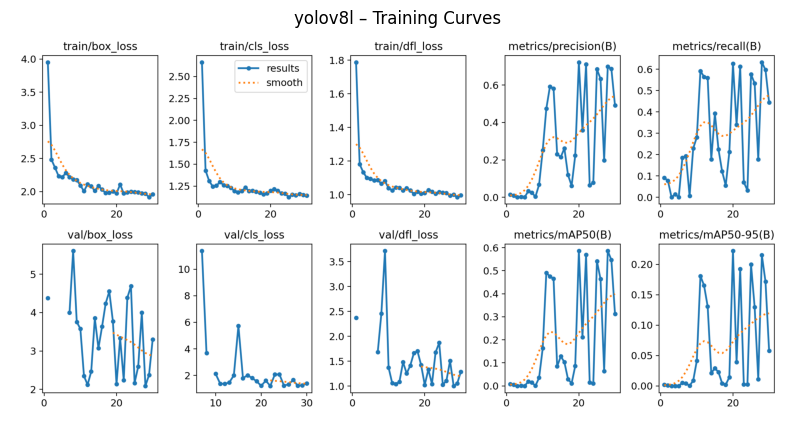

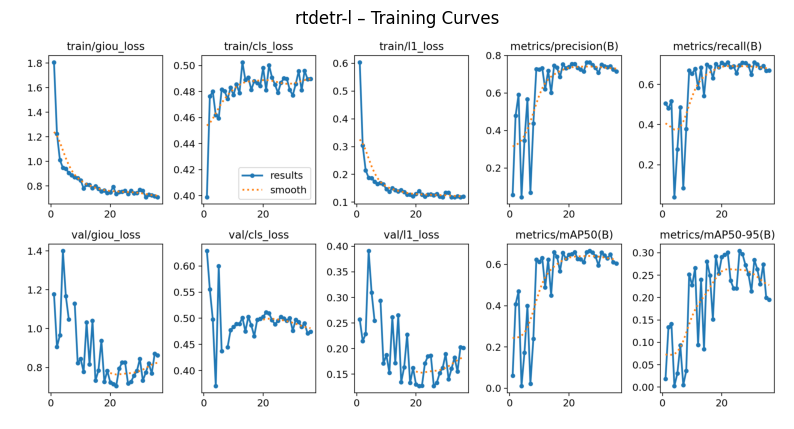

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

def show_plot(path, title=None):
    img = Image.open(path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

RUN_DIR = Path("runs/detect")

for name in MODELS_TO_TRAIN.keys():
    plot_path = RUN_DIR / f"{name}_final" / "results.png"
    if plot_path.exists():
        show_plot(plot_path, title=f"{name} – Training Curves")


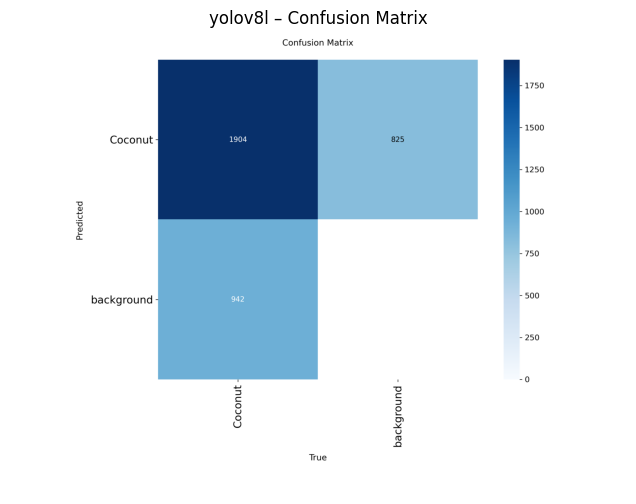

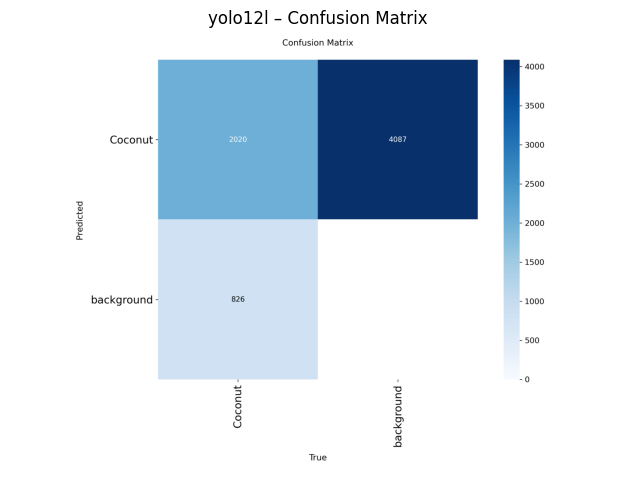

In [24]:
for name in MODELS_TO_TRAIN.keys():
    cm_path = RUN_DIR / f"{name}_final" / "confusion_matrix.png"
    if cm_path.exists():
        show_plot(cm_path, title=f"{name} – Confusion Matrix")


## Step 4 : Model Evaluation on test set

In [25]:
TEST_IMAGES = YOLO_DIR / "test"
TEST_IMAGES = str(TEST_IMAGES)

def load_model(name, weights):
    if "rtdetr" in name.lower():
        return RTDETR(weights)
    return YOLO(weights)


In [ ]:
for name in MODELS_TO_TRAIN.keys():
    weights = f"runs/detect/{name}_final/weights/best.pt"
    model = load_model(name, weights)

    model.predict(
        source=TEST_IMAGES,
        imgsz=IMG_SIZE,
        conf=0.25,
        iou=0.7,
        save=True,
        save_txt=True,
        save_conf=True,
        project="results/predictions",
        name=name,
        device=0
    )


In [27]:
import os
import cv2
import matplotlib.pyplot as plt

BASE_DIR = "runs/detect/results/predictions"
MODELS = ["yolo12l", "yolov8l", "rtdetr-l"]

# only image extensions
IMG_EXTS = (".jpg", ".png", ".jpeg")

# get one valid image name
image_name = next(
    f for f in os.listdir(os.path.join(BASE_DIR, MODELS[0]))
    if f.lower().endswith(IMG_EXTS)
)

plt.figure(figsize=(15, 5))

for i, model in enumerate(MODELS):
    img_path = os.path.join(BASE_DIR, model, image_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(MODELS), i + 1)
    plt.imshow(img)
    plt.title(model)
    plt.axis("off")

plt.tight_layout()
plt.show()
